본문은 권창현 교수님의 줄리아 책, julia programming for Operations Rsearch를 참고하여 정리하였습니다. (Julia 1.1.0)
> https://www.softcover.io/read/7b8eb7d0/juliabook2/frontmatter

# Chapter 10. Lagrangian Relaxation
예전에 R로 짰었는데, 이번에는 줄리아이다!
LR은 MILP 문제를 푸는데 유용하다. 키 아이디어는 hard constraint를 relax해서 좀 더 쉬운 문제를 푸는 것이다. 이 쉬운 문제들을 여러번 풀면서 Lagrangian multipliers의 적당한 값을 업데이트 한다.

## 10.1 Introduction

Fisher(2004)의 논문을 바탕으로 코드를 구현하였다.
>Fisher, Marshall L. "The Lagrangian relaxation method for solving integer programming problems." Management science 50.12_supplement (2004): 1861-1871.

다음 문제를 고려해보자.

$$Z^* = \min \mathbf{c^Tx}$$

$$\mathbf{s.t\quad Ax=b}$$

$$\mathbf {Dx \le e}$$

$$\mathbf {x \ge 0, Integer.}$$
    
$\lambda$ 는 첫번째 제약조건에 대한 dual variable이라고 하자. 첫번째 제약조건을 완화함으로써 Lagrangian problem은 다음과 같이 만들수 있다.

$$Z_D(\lambda) = \min \mathbf{c^Tx}+\lambda^T(\bf{Ax-b})$$

$$
\mathbf{s.t\quad Dx \le e}
$$

$$
\mathbf{x \ge 0, Integer}
$$

라그랑지안 문제는 원래 문제에 비해 쉬워진다. 간단한 LR 방법은 다음과 같이 요약할 수 있다.

- **Step 0:** 초기 람다 값인 $\lambda^0$를 예측한다.
- **Step 1:** $\lambda^k$가 주어졌을 때, 라그랑지안 문제를 풀고 $Z_D(\lambda^k)$를 구한다. 라그랑지안 문제에서 얻은 $\bf{x}^k_D$의 솔루션을 구하는데, 이는 원래 문제에서는 infeasible할 수 있다.
- **Step 2:** $\lambda^k$와 $\bf{x}^k_D$ 값이 주어졌을 때, feasible 솔루션 $\bf{x}^k$를 *어떤 벙법*으로 구한다.
- **Step 3:** *어떤 벙법*을 반복하면서 $\lambda^k$와 $\lambda^{k+1}$을 업데이트한다.

### 10.1.1 Lower and Upper Bound

원 문제를 풂으로써 우리의 목적은 목적값인 $Z^*$의 최적 값을 계산하는 것이다.우리의 목표는 알 수 없는 최적 목적값의 바운드를 위아래로 줄여나가는 것이다. 즉, 다음과 같은 관계에서
$$Z_{LB} \ge Z^* \ge Z_{UB}$$
최적 목적 값은 $Z_{LB} = Z_{UB} = Z^*$이 될 것이다. 우리는 이 사이의 갭을 optimal gap이라고 할것이며, 다음과 같이 나타낼 수 있다.

$$Optimal \ Gap = \frac{Z_{UB}-Z_{LB}}{Z_{UB}} \times 100 % $$


따라서 라그랑지안 문제는 다음과 같은 특징을 가지고 있다.

$Z_D(\lambda)\le Z^* \mbox{for all } \lambda \le 0$ , 라그랑지안 문제에서 최적 목적값은 원래 값보다 무조건 작다. (최소 문제인 경우!, 즉, 완화 해주었으니깐 더 좋은 값을 가질 수 밖에 없다는 것.)

그러므로 LR은 더 낮은 lower-bound를 제공할 수 밖에 없다. 우리는 람다를 바꿔가면서 이 lower-bound가 최대한 원래 문제와 같은 목적함수값을 구하고 싶은 것이다.


_**그렇다면 어떻게 람다를 업데이트 할 것인가?**_

뒤에서 설명할 것이다.


일단 우리는 완전성 조건 (integrality condition)을 제거한 LP relaxation이라고 불리는 relaxation 방법을 고려해 볼 수 있다. 

$$Z_{LP} = \min \mathbf{c^Tx}$$

$$
\mathbf{s.t\quad Ax=b \\
Dx \le e \\
x \ge 0}
$$


당연히 $Z_{LP}$는 원래 문제의 최적 목적값보다는 낮다. 이는 lower-bound가 될 것이다.
$$Z_{LP}\le Z^*$$

upper-bound는 임의의 feasiable solution $\bf x$로 이루어진 $\bf{c^Tx}$이 될 것이다.
$$Z^*\le\bf{c^Tx}$$

현실적인 질문은 어떻게 *좋은* upper-bound를 찾느냐 이다. 가능한 방법 중 하나로 라그랑지안 문제의 해를 이용하는 것이다. $\lambda^k$가 주어졌을때의 라그랑지안 문제를 풀면 ${\bf x}^k_D$를 얻는데, 이는 infeasible이다. 혹은 optimal솔루션을 찾을 것이다. ${\bf x}^k_D$ 값의 일부 변수를 고정하고, 다른 변수를 feasible하게 수정하거나, 휴리스틱 알고리즘을 이용해서 feasible soluion ${\bf x}^k_D$를 얻을 수 있다.


### 10.1.2 Subgradient Optimization

$Z_D(\lambda)\le Z^* \mbox{for all } \lambda \le 0$ 이므로, 다음을 구하는 것이 원래 문제의 최적 해를 구하는것이다.

$$\max_{\lambda \le 0} Z_D(\lambda)$$

이 문제를 풀기위해, subgradient optimization 방법을 사용하는데, 다음과 같이 업데이트 된다.

$$\lambda^{k+1}=\max \begin{Bmatrix} \lambda^k+t_k(\bf{Ax}^k_D-b),0 \end{Bmatrix}$$

where $t_k>0$ 이며, 이를 step size라고 한다. step size는 다음과 같이 계산된다.
$$t_k = \frac{ \theta_k ( Z_\text{UB} - Z_D({\lambda}^k) ) }
         {  || {A}{x}_D^k - b ||^2 }$$
         

## 10.2 The -$p$-Median Problem

facility location 문제를 LR로 풀어볼 것이다.
>Daskin, Mark S., and Kayse Lee Maass. "The p-median problem." Location science. Springer, Cham, 2015. 21-45.

$$
\begin{align*}
  Z^* = \min \quad & \sum_{i\in\mathcal I} \sum_{j\in\mathcal J} d_j c_{ij} x_{ij} \\
\text{s.t.} \quad
& \sum_{i\in\mathcal I} x_{ij} = 1  \qquad \forall j\in\mathcal J \\
& \sum_{i\in\mathcal I} y_i = p  \\
& x_{ij} \leq y_i \qquad \forall i\in\mathcal I, j\in\mathcal J \\
& y_i \in \{0,1\} \qquad \forall i\in\mathcal I \\
& x_{ij} \geq 0 \qquad \forall i\in\mathcal I, j\in\mathcal J
\end{align*}
$$



In [7]:
using DelimitedFiles
d, header = readdlm("./dataset&result/demand.csv", ',', header=true)
data = readdlm("./dataset&result/cost.csv", ',')
cc = data[2:end, 2:end]
c = convert(Array{Float64,2}, cc)

7×10 Array{Float64,2}:
 10.0   7.0  11.0  12.0  32.0  15.0  20.0  26.0   4.0  41.0
 13.0  17.0  31.0  37.0  21.0   5.0  13.0  15.0  14.0  12.0
  4.0  13.0  14.0  22.0   8.0  31.0  26.0  11.0  12.0  23.0
 21.0  21.0  13.0  18.0   9.0  27.0  11.0  16.0  26.0  32.0
 32.0  18.0  11.0  14.0  11.0  11.0  16.0  32.0  34.0   8.0
 15.0   9.0  13.0  12.0  14.0  15.0  32.0   8.0  12.0   9.0
 28.0  32.0  15.0   2.0  17.0  12.0   9.0   6.0  11.0   6.0

In [14]:
println(d)
println(header)

[10.0; 6.0; 20.0; 32.0; 15.0; 28.0; 3.0; 19.0; 8.0; 13.0]
AbstractString["demand"]


In [13]:
data

8×11 Array{Any,2}:
 ""      "C1"    "C2"    "C3"    "C4"  …    "C7"    "C8"    "C9"    "C10"
 "L1"  10       7      11      12         20      26       4      41     
 "L2"  13      17      31      37         13      15      14      12     
 "L3"   4      13      14      22         26      11      12      23     
 "L4"  21      21      13      18         11      16      26      32     
 "L5"  32      18      11      14      …  16      32      34       8     
 "L6"  15       9      13      12         32       8      12       9     
 "L7"  28      32      15       2          9       6      11       6     

In [15]:
typeof(cc)

Array{Any,2}

In [16]:
@assert length(d) == size(c,2) #assert 매크로는 주어진 구문을 검사하는 역할을 한다. 만약 에러면 false를 결과로 내고, true인 경우 다음 코드로 넘어간다.

In [17]:
locations = 1:size(c,1) # the set, I
customers = 1:length(d) # the set, J

1:10

### 10.2.2 Solving the $p$-Median Problem Optimally

In [19]:
using JuMP, Cbc
function optimal(p)
  m = Model(Cbc.Optimizer)

  @variable(m, x[i in locations, j in customers] >= 0)
  @variable(m, y[i in locations], Bin)

  @objective(m, Min, sum( d[j]*c[i,j]*x[i,j]
                     for i in locations, j in customers) )

  @constraint(m, [j in customers], sum( x[i,j] for i in locations) == 1)
  @constraint(m, sum( y[i] for i in locations) == p)
  @constraint(m, [i in locations, j in customers], x[i,j] <= y[i] )

  JuMP.optimize!(m)

  Z_opt = JuMP.objective_value(m)
  x_opt = JuMP.value.(x)
  y_opt = JuMP.value.(y)

  return Z_opt, x_opt, y_opt
end

┌ Info: Recompiling stale cache file /home/sugyeong/.julia/compiled/v1.1/JuMP/DmXqY.ji for JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/sugyeong/.julia/compiled/v1.1/Cbc/ARPfV.ji for Cbc [9961bab8-2fa3-5c5a-9d89-47fab24efd76]
└ @ Base loading.jl:1184


optimal (generic function with 1 method)

### 10.2.3 Lagrangian Relaxation

\begin{align*}
  Z_D({\lambda}) = \min \quad & \sum_{i\in\mathcal I} \sum_{j\in\mathcal J} d_j c_{ij} x_{ij}
              + \sum_{j\in\mathcal J} \lambda_j \bigg(1 - \sum_{i\in\mathcal I} x_{ij} \bigg) \\
 = \min \quad & \sum_{i\in\mathcal I} \sum_{j\in\mathcal J} ( d_j c_{ij} - \lambda_j ) x_{ij}
      + \sum_{j\in\mathcal J} \lambda_j \\
\text{s.t.} \quad
&  \sum_{i\in\mathcal I} y_i = p  \\
&  x_{ij} \leq y_i  \qquad \forall i\in\mathcal I, j\in\mathcal J \\
&  y_i \in \{0,1\}  \qquad \forall i\in\mathcal I \\
&  x_{ij} \geq 0  \qquad \forall i\in\mathcal I, j\in\mathcal J
\end{align*}


### 10.2.4 Finding Lower Bound

**Step 1**
$$v_i = \sum_{j\in\mathcal J} \min \{ 0, d_j c_{ij} - \lambda_j \}$$


**Step 4**

$$Z_D({\lambda}) = \min \quad \sum_{i\in\mathcal I} \sum_{j\in\mathcal J} d_j c_{ij} x_{ij}
              + \sum_{j\in\mathcal J} \lambda_j \bigg(1 - \sum_{i\in\mathcal I} x_{ij} \bigg)$$

In [20]:
function lower_bound(lambda)
  # Step 1: Computing v
  v = Array{Float64}(undef, size(locations))
  for i in locations
    v[i] = 0
    for j in customers
      v[i] = v[i] + min(0, d[j]*c[i,j] - lambda[j] )
    end
  end
  
  # v: [-8.0; -1.0; 0.0; -7.0; 0.0; 0.0; -13.0]

  # Step 2: Sorting v from the most negative to zero
  idx = sortperm(v) # 작은 값의 인덱스를 순서대로 준다. 제일 좋은 값의 index!

  # idx: [7; 1; 4; 2; 3; 5; 6]

  # Step 3: Determine y # 후보에는 1, 아닌곳은 0!
  y = zeros(Int, size(locations))
  y[idx[1:p]] .= 1
  # y: [1; 0; 0; 1; 0; 0; 1] 

  # Step 4: Determine x
  x = zeros(Int, length(locations), length(customers))
  for i in locations, j in customers
    if y[i]==1 && d[j]*c[i,j]-lambda[j]<0 # &&=and
      x[i,j] = 1
    end
  end

  # Computing the Z_D(lambda^k)
  Z_D = 0.0
  for j in customers
    Z_D = Z_D + lambda[j]
    for i in locations
      Z_D = Z_D + d[j]*c[i,j]*x[i,j] - lambda[j]*x[i,j]
    end
  end

  return Z_D, x, y
end

lower_bound (generic function with 1 method)

In [27]:
lambda = zeros(size(customers))
p = 3

v = Array{Float64}(undef, size(locations))
for i in locations
  v[i] = 0
  for j in customers
    v[i] = v[i] + min(0, d[j]*c[i,j] - lambda[j] )
  end
end
v

7-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [28]:
idx = sortperm(v)

7-element Array{Int64,1}:
 1
 2
 3
 4
 5
 6
 7

In [30]:
y = zeros(Int, size(locations))
y[idx[1:p]] .= 1
y

7-element Array{Int64,1}:
 1
 1
 1
 0
 0
 0
 0

In [32]:
x = zeros(Int, length(locations), length(customers))
for i in locations, j in customers
  if y[i]==1 && d[j]*c[i,j]-lambda[j]<0
    x[i,j] = 1
  end
end
x

7×10 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0

In [34]:
Z_D = 0.0
for j in customers
  Z_D = Z_D + lambda[j]
  for i in locations
    Z_D = Z_D + d[j]*c[i,j]*x[i,j] - lambda[j]*x[i,j]
  end
end
Z_D  

0.0

### 10.2.5 Finding Upper Bound

In [21]:
function upper_bound(y)
  # Computing x, given y
  x = zeros(Int, length(locations), length(customers))
  for j in customers
    idx = argmin( c[:,j] + (1 .- y) .* maximum(c) )
    x[idx,j] = 1
  end

  # Computing Z
  Z = 0.0
  for i in locations
    for j in customers
      Z = Z + d[j]*c[i,j]*x[i,j]
    end
  end

  return Z, x
end

upper_bound (generic function with 1 method)

In [49]:
x = zeros(Int, length(locations), length(customers))
println(x)
for j in customers
  idx = argmin( c[:,j] + (1 .- y) .* maximum(c) ) #argmin: 벡터에서 가장 작은 값을 가지는 인덱스를 찾아줌
  println(idx,j)
  x[idx,j] = 1
  println(x)
end

[0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0]
31
[0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0]
12
[0 1 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0]
13
[0 1 1 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0]
14
[0 1 1 1 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0]
35
[0 1 1 1 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 1 0 0 0 1 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0]
26
[0 1 1 1 0 0 0 0 0 0; 0 0 0 0 0 1 0 0 0 0; 1 0 0 0 1 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0

In [51]:
x

7×10 Array{Int64,2}:
 0  1  1  1  0  0  0  0  1  0
 0  0  0  0  0  1  1  0  0  1
 1  0  0  0  1  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0

### 10.2.6 Updating the Lagrangian Multiplier

$$\lambda^{k+1}_j = \lambda^k_j + t_k \bigg( 1 - \sum_{i\in\mathcal I} x_{Dij}^k \bigg)$$

$$t_k = \frac{ \theta_k ( Z_\text{UB} - Z_D({\lambda}^k) ) }
         {  \sum_{j\in\mathcal J} \bigg( 1 - \sum_{i\in\mathcal I} x_{Dij}^k \bigg)^2 }$$
         


In [52]:
function lagrangian_relaxation(p)
    # The maximum number of iterations allowed
    MAX_ITER = 10000

    # To track the upper and lower bounds
    UB = Array{Float64}(undef, 0)
    LB = Array{Float64}(undef, 0)

    # The best-known upper and lower bounds
    Z_UB = Inf
    Z_LB = -Inf

    # The best-known feasible solutions
    x_best = zeros(length(locations), length(customers))
    y_best = zeros(length(locations))

    # Initial multiplier
    lambda = zeros(size(customers))

    for k=1:MAX_ITER
      # Obtaining the lower and upper bounds
      Z_D, x_D, y = lower_bound(lambda)
      Z, x = upper_bound(y)

      # Updating the upper bound
      if Z < Z_UB
        Z_UB = Z
        x_best = x
        y_best = y
      end

      # Updating the lower bound
      if Z_D > Z_LB
        Z_LB = Z_D
      end

      # Adding the bounds from the current iteration to the record
      push!(UB, Z)
      push!(LB, Z_D)

      # Determining the step size and updating the multiplier
      theta = 1.0
      residual = 1 .- transpose(sum(x_D, dims=1))
      t = theta * (Z_UB - Z_D) / sum(residual.^2)
      lambda = lambda + t * residual

      # Computing the optimality gap
      opt_gap = (Z_UB-Z_LB) / Z_UB
      if opt_gap < 0.000001
        break
      end
    end

    return Z_UB, x_best, y_best, UB, LB
end




lagrangian_relaxation (generic function with 1 method)

In [62]:
Z_opt, x_opt, y_opt = optimal(p)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Oct  7 2019 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 1029 - 0.00 seconds
Cgl0004I processed model has 81 rows, 77 columns (7 integer (7 of which binary)) and 217 elements
Cbc0012I Integer solution of 1029 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 1029, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cuts at root node changed objective from 1029 to 1029
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Knapsack was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Clique was tried 0 times and created 0 cuts of which 0 were act

(1029.0, 2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:7
    Dimension 2, 1:10
And data, a 7×10 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0, 1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:7
And data, a 7-element Array{Float64,1}:
 0.0
 1.0
 1.0
 0.0
 0.0
 0.0
 1.0)

In [54]:
println(Z_opt)
println(y_opt)

1029.0
1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:7
And data, a 7-element Array{Float64,1}:
 0.0
 1.0
 1.0
 0.0
 0.0
 0.0
 1.0


In [63]:
Z_UB, x_best, y_best, UB, LB = lagrangian_relaxation(p)

(1029.0, [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 1 1], [0, 1, 1, 0, 0, 0, 1], [1382.0, 1073.0, 1181.0, 1029.0, 1072.0, 1073.0, 1029.0, 1072.0, 1073.0, 1029.0  …  1029.0, 1073.0, 1072.0, 1029.0, 1072.0, 1029.0, 1072.0, 1029.0, 1072.0, 1029.0], [0.0, 464.2, 880.933, 934.547, 924.036, 939.354, 964.13, 977.495, 984.033, 996.843  …  1028.62, 1028.67, 1028.89, 1028.86, 1028.93, 1028.97, 1028.98, 1028.99, 1029.0, 1029.0])

In [56]:
println(Z_UB)
println(y_best)

1029.0
[0, 1, 1, 0, 0, 0, 1]


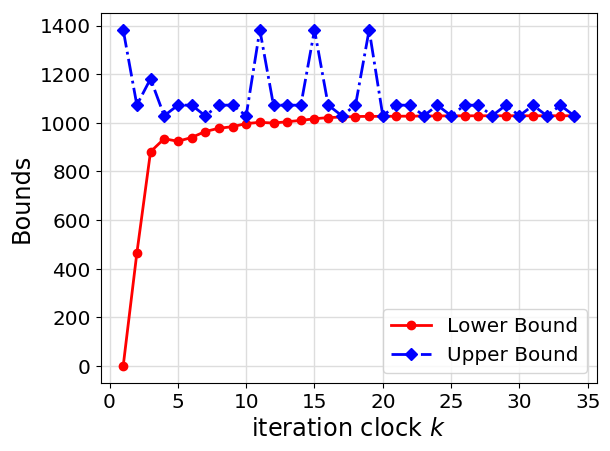

In [70]:
using PyPlot



iter = 1:length(LB)
fig = figure()

# Plotting two datasets
plot(iter, LB, color="red", linewidth=2.0, linestyle="-",
   marker="o", label="Lower Bound")
plot(iter, UB, color="blue", linewidth=2.0, linestyle="-.",
   marker="D", label="Upper Bound")

# Labeling axes
xlabel(L"iteration clock $k$", fontsize="xx-large")
ylabel("Bounds", fontsize="xx-large")

# Putting the legend and determining the location
legend(loc="lower right", fontsize="x-large")

# Add grid lines
grid(color="#DDDDDD", linestyle="-", linewidth=1.0)
tick_params(axis="both", which="major", labelsize="x-large")


In [69]:
using JuMP, Cbc, DelimitedFiles, PyPlot

# Solving the p-median problem by Lagrangian Relaxation
p = 3

# Reading demand data
d, header = readdlm("./dataset&result/demand.csv", ',', header=true)

# Reading transportation cost data
data = readdlm("./dataset&result/cost.csv", ',')
cc = data[2:end, 2:end]
c = convert(Array{Float64,2}, cc)

# the length of 'd' and the number of columns in 'c' must match
@assert length(d) == size(c,2)

locations = 1:size(c,1) # the set, I
customers = 1:length(d) # the set, J

# making these data global so that any function can access data



function optimal(p)
  global locations, customers, c
  m = Model(Cbc.Optimizer)

  @variable(m, x[i in locations, j in customers] >= 0)
  @variable(m, y[i in locations], Bin)

  @objective(m, Min, sum( d[j]*c[i,j]*x[i,j]
                     for i in locations, j in customers) )

  @constraint(m, [j in customers], sum( x[i,j] for i in locations) == 1)
  @constraint(m, sum( y[i] for i in locations) == p)
  @constraint(m, [i in locations, j in customers], x[i,j] <= y[i] )

  JuMP.optimize!(m)

  Z_opt = JuMP.objective_value(m)
  x_opt = JuMP.value.(x)
  y_opt = JuMP.value.(y)

  return Z_opt, x_opt, y_opt
end



function lower_bound(lambda)
  # Step 1: Computing v
  v = Array{Float64}(undef, size(locations))
  for i in locations
    v[i] = 0
    for j in customers
      v[i] = v[i] + min(0, d[j]*c[i,j] - lambda[j] )
    end
  end

  # Step 2: Sorting v from the most negative to zero
  idx = sortperm(v)

  # Step 3: Determine y
  y = zeros(Int, size(locations))
  y[idx[1:p]] .= 1

  # Step 4: Determine x
  x = zeros(Int, length(locations), length(customers))
  for i in locations, j in customers
    if y[i]==1 && d[j]*c[i,j]-lambda[j]<0
      x[i,j] = 1
    end
  end

  # Computing the Z_D(lambda^k)
  Z_D = 0.0
  for j in customers
    Z_D = Z_D + lambda[j]
    for i in locations
      Z_D = Z_D + d[j]*c[i,j]*x[i,j] - lambda[j]*x[i,j]
    end
  end

  return Z_D, x, y
end



function upper_bound(y)
  # Computing x, given y
  x = zeros(Int, length(locations), length(customers))
  for j in customers
    idx = argmin( c[:,j] + (1 .- y) .* maximum(c) )
    x[idx,j] = 1
  end

  # Computing Z
  Z = 0.0
  for i in locations
    for j in customers
      Z = Z + d[j]*c[i,j]*x[i,j]
    end
  end
  return Z, x
end

function lagrangian_relaxation(p)
    # The maximum number of iterations allowed
    MAX_ITER = 10000

    # To track the upper and lower bounds
    UB = Array{Float64}(undef, 0)
    LB = Array{Float64}(undef, 0)

    # The best-known upper and lower bounds
    Z_UB = Inf
    Z_LB = -Inf

    # The best-known feasible solutions
    x_best = zeros(length(locations), length(customers))
    y_best = zeros(length(locations))

    # Initial multiplier
    lambda = zeros(size(customers))

    for k=1:MAX_ITER
      # Obtaining the lower and upper bounds
      Z_D, x_D, y = lower_bound(lambda)
      Z, x = upper_bound(y)

      # Updating the upper bound
      if Z < Z_UB
        Z_UB = Z
        x_best = x
        y_best = y
      end

      # Updating the lower bound
      if Z_D > Z_LB
        Z_LB = Z_D
      end

      # Adding the bounds from the current iteration to the record
      push!(UB, Z)
      push!(LB, Z_D)

      # Determining the step size and updating the multiplier
      theta = 1.0
      residual = 1 .- transpose(sum(x_D, dims=1))
      t = theta * (Z_UB - Z_D) / sum(residual.^2)
      lambda = lambda + t * residual

      # Computing the optimality gap
      opt_gap = (Z_UB-Z_LB) / Z_UB
      if opt_gap < 0.000001
        break
      end
    end

    return Z_UB, x_best, y_best, UB, LB
end


# Finding the exact optimal solution
Z_opt, x_opt, y_opt = optimal(p)
# Finding a solution by Lagrangian relaxation
Z_UB, x_best, y_best, UB, LB = lagrangian_relaxation(p)



iter = 1:length(LB)
fig = figure()

# Plotting two datasets
plot(iter, LB, color="red", linewidth=2.0, linestyle="-",
   marker="o", label="Lower Bound")
plot(iter, UB, color="blue", linewidth=2.0, linestyle="-.",
   marker="D", label="Upper Bound")

# Labeling axes
xlabel(L"iteration clock $k$", fontsize="xx-large")
ylabel("Bounds", fontsize="xx-large")

# Putting the legend and determining the location
legend(loc="lower right", fontsize="x-large")

# Add grid lines
grid(color="#DDDDDD", linestyle="-", linewidth=1.0)
tick_params(axis="both", which="major", labelsize="x-large")

# Title
title("Lower and Upper Bounds")
savefig("./dataset&result/iterations.png")
savefig("./dataset&result/iterations.pdf")
close(fig)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Oct  7 2019 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 1029 - 0.00 seconds
Cgl0004I processed model has 81 rows, 77 columns (7 integer (7 of which binary)) and 217 elements
Cbc0012I Integer solution of 1029 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 1029, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cuts at root node changed objective from 1029 to 1029
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Knapsack was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Clique was tried 0 times and created 0 cuts of which 0 were act